In [19]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import copy

from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import *
from information_scores import *
import os
import scipy.io
import pandas as pd
from scipy.io import loadmat
from pathlib import Path
import math
from scipy.misc import derivative
from scipy import signal
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [2]:
# Loading DATA
train_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-08-19-16-02_5sec.mat"
train_file2 = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)
test_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [62]:
# SINDy Function Definitions

def build_library(X,Y):
    
    # obtain size of state space
    l = X.shape[0]
    n = X.shape[1]
    m = Y.shape[1]
    
    # add in a constant by making a column of ones
    Theta = np.ones((l,1))
    function_label = ['1']
    
    # add in first order polynomials of all the states
    for i in range(n):
        state = np.array([X[:,i]]).T
        Theta = np.append(Theta,state,axis=1)
        function_label.append('x'+str(i))
    
    # add in sines of all states 
    for i in range(n):
        sine_state = np.array([np.sin(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('sin x'+str(i))
        
    # add in cosines of all states  
    for i in range(n):
        sine_state = np.array([np.cos(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('cos x'+str(i))
        
    
    # add in controls
    for i in range(m):
        control = np.array([Y[:,i]]).T
        Theta = np.append(Theta,control,axis=1) 
        function_label.append('u'+str(i))
 
    return Theta,function_label

def Sparse_Regression(Theta,dXdt,thresh):
    
    lassoreg = Lasso(alpha=thresh,normalize=True, max_iter=1e5) # sparsify!!!!! Hell yeah!!!
    lassoreg.fit(Theta,dXdt)
    Xi = lassoreg.coef_
    
    return Xi.T

# def Sparse_Regression(Theta,dXdt,thresh):
    
#     elasticreg = ElasticNet(alpha=thresh, random_state = 0) # sparsify!!!!! Hell yeah!!!
#     elasticreg.fit(Theta,dXdt)
#     Xi = elasticreg.coef_
    
#     return Xi.T


In [63]:
dt = 0.01 # sampling time in seconds

X = train_state_traj2.T
Y = train_action_traj2.T
dX = np.zeros((X.shape[0]-4))

for i in range(X.shape[1]):
    Xi = X[:,i]
    dXi = (1/(12*dt)) * (-Xi[4:] + 8*Xi[3:-1] - 8*Xi[1:-3] + Xi[:-4])
    Xi = Xi[2:-2]
    dX = np.vstack([dX,dXi])

Y = Y[2:-2,:] # final output values
X = X[2:-2,:] # final state values
Xprime = dX[1:,:].T # state derivatives


print(Y.shape,X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

Theta,function_label = build_library(X,Y) # build the lbrary of functions (Theta)
threshold = 0.01 # thresholding paramater for sparsification
Xi = Sparse_Regression(Theta,Xprime,threshold) # obtain Xi ("ksi") that gives us the coefficients
Xi = np.asarray(Xi)
print(Xi.shape)

(1052, 3) (1052, 9) (1052, 9)
(31, 9)


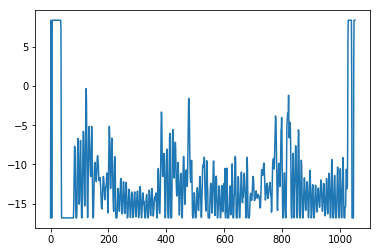

In [79]:
l = 0
y = Y[:,l]
plt.plot(y)

In [64]:
states = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']
df = pd.DataFrame(Xi,index = function_label, columns = states)
A = df.head(40)
A

,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
x0,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,206.922743,-0.000000
x1,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
x2,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,219.716651,-0.000000,-0.000000
x3,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,30.641184,0.000000
x4,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-6.898442
x5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,9.393689,-0.000000,0.279440
x6,0.000000,0.000000,-0.000000,0.692474,-0.000000,-0.000000,16.127543,1.057955,0.906600
x7,0.000000,0.104809,-0.000000,0.154391,0.667373,0.000000,18.540116,13.788791,0.269370
x8,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-1.375721,0.000000


In [65]:
def RoboFly_dynamics(t,X,u,Xi):
    # extract control inputs
    u0 = u[0]; u1 = u[1]; u2 = u[2]
    # extract states
    x0 = X[0];x1 = X[1];x2 = X[2];x3 = X[3];x4 = X[4];x5 = X[5]
    x6 = X[6];x7 = X[7];x8 = X[8]
    # define library
    library = (np.array([1,x0,x1,x2,x3,x4,x5,x6,x7,x8, np.sin(x0),np.sin(x1),np.sin(x2),np.sin(x3),np.sin(x4),np.sin(x5),
             np.sin(x6),np.sin(x7),np.sin(x8),np.cos(x0),np.cos(x1),np.cos(x2),np.cos(x3),np.cos(x4),np.cos(x5),np.cos(x6),
                np.cos(x7),np.cos(x8),u0,u1,u2]))
    # obtain the state equations
    dXdt = np.dot(Xi.T,library)
    
    #unpack states
    x0dot = dXdt[0]; x1dot = dXdt[1]; x2dot = dXdt[2]; x3dot = dXdt[3]; x4dot = dXdt[4]; x5dot = dXdt[5];
    x6dot = dXdt[6]; x7dot = dXdt[7]; x8dot = dXdt[8];
        

    return [x0dot, x1dot, x2dot, x3dot, x4dot, x5dot, x6dot, x7dot, x8dot]

In [66]:
# define number of iterations (usually the number of control inputs)
num_iter = X.shape[0]
# initial condition
initial_state = np.array([X[0,:]]).T
u = np.array([Y[0,:]]).T

# place holder for trajectory
predicted_trajectory = []

# intialize time values
initial_time = 0
final_time = dt
# Eveolve the ODE (as told by SINDYc) in time
for i in range(num_iter-1):
    print(i)
    # reshape initial states
    initial_state = initial_state.reshape(9,)
    # define timespan for ODE time stepping
    tspan = np.asarray([initial_time,final_time])
    # forward propagation
    next_state = solve_ivp(RoboFly_dynamics, tspan, initial_state , method = "LSODA", args = (u,Xi,))
    next_state1 = next_state.y[:,-1] # grab the latest evolved trajectory
    # collect states
    predicted_trajectory.append(next_state1)
    # update state
    initial_state = next_state1
    # update control action
    u = Y[i+1,:] 
    # update time vectors
    initial_time = final_time
    final_time = final_time + dt
    
predicted_trajectory = np.asarray(predicted_trajectory)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [67]:
predicted_trajectory = np.asarray(predicted_trajectory)
predicted_trajectory.shape

(317, 9)

# median filter the trajectory

In [68]:
def median_filter(signal,threshold,window_size,upper_thresh = True):
    
    n = len(signal)
    
    # visual-picked threshold
    threshold = 40

    # find data values above or below the threshold
    if upper_thresh:
        print("upper")
        suprathresh = np.where( signal > threshold )[0]
    else:
        print("lower")
        suprathresh = np.where( signal < threshold )[0]

    # loop through suprathreshold points and set to median of k
    k = (window_size-1)//2
    for ti in range(0,len(suprathresh)):

        # lower and upper bounds
        lowbnd = np.max((1,suprathresh[ti]-k))
        uppbnd = np.min((suprathresh[ti]+k,n))

        # compute median of surrounding points
        signal[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])
        
    return signal

In [69]:
# Median Filter

# initialize the parameters
filter_traj = np.zeros_like(predicted_trajectory)
threshold = 50
window_size = 150

# apply the median filter to filter positive peaks
num_signals = predicted_trajectory.shape[1]
for i in range(num_signals):
    state_max = np.max(predicted_trajectory[:,i])
    filter_traj[:,i] = median_filter(predicted_trajectory[:,i],state_max,window_size)
    
# apply the median filter to filter negative peaks
num_signals = predicted_trajectory.shape[1]
for i in range(num_signals):
    state_min = np.min(predicted_trajectory[:,i])
    filter_traj[:,i] = median_filter(predicted_trajectory[:,i],state_min,window_size,upper_thresh = False)
    

upper
upper
upper
upper
upper
upper
upper
upper
upper
lower
lower
lower
lower
lower
lower
lower
lower
lower


In [70]:
traj_no = 1
filter_single = filter_traj[:,traj_no]
min_state_true = np.min(predicted_trajectory[traj_no,:])
print(np.min(filter_single),np.max(filter_single))

-5.4073126414335423e+20 -69.0014430337099


In [71]:
print(np.where(filter3<10*min_state_true)[0])

[ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 28

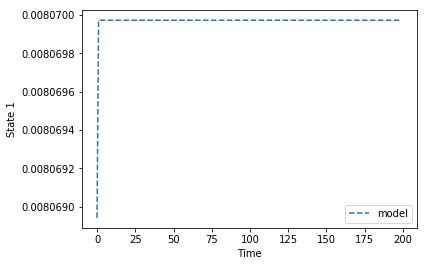

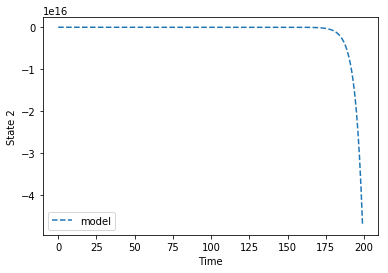

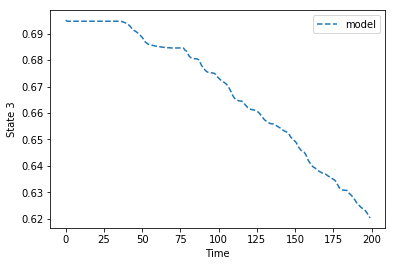

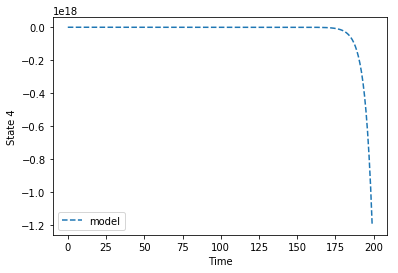

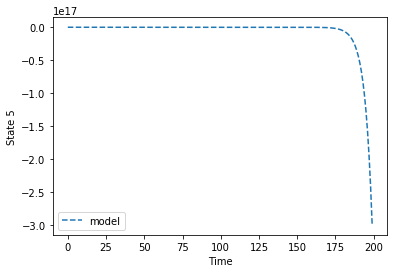

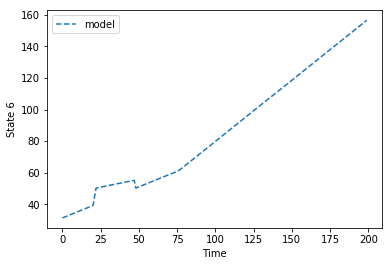

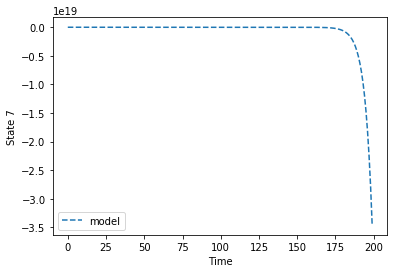

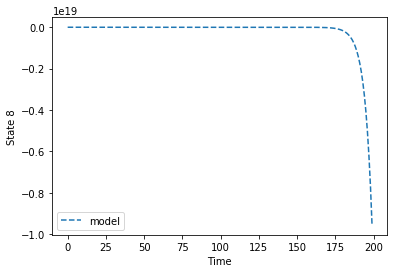

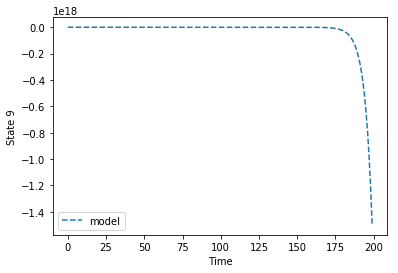

In [74]:
for i in range(9):
    #plt.plot(test_state_traj[i,0:200],label ='data')
    plt.plot(filter_traj[0:200,i],label = 'model', linestyle='--')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State '+str(i+1))
    #smin = np.min(test_state_traj[i,:])
    #smax = np.max(test_state_traj[i,:])
    #plt.ylim(smin,smax)
    plt.show()

In [36]:
state2  = test_state_traj[1,:]
max_state2 = np.max(state2)


0.23460786774361886
